In [1]:
import numpy as np
import numpy.linalg as nplin
import matplotlib.pyplot as plt

## Defining variables from the given information

In [2]:
samples = 2000           # number of samples
params = 2               # number of parameters
bins = 31                # number of bins of redshift in the data

## Calculation of Likelihood

In [3]:
# Defining required functions

def Eta(a, Omega_m):
    if Omega_m >= 0.9999:         # Imposing these conditions because physical value of omega is considered between 0.2 to 1 
        Omega_m = 0.9999          # according to the question.
    elif Omega_m <= 0.2:          
        Omega_m = 0.2
    else:
        pass

    s = ((1.0-Omega_m)/Omega_m)**(1.0/3.0)
    ETA = 2.0*(np.sqrt((s**3.0) + 1.0))*((1.0/(a**4)) - 0.1540*(s/(a**3)) + 0.4304*((s*s)/(a*a)) + 0.19097*((s**3)/a) + 0.066941*(s**4))**(-1.0/8.0)
    return ETA


def Distance_L(z, Omega_m):          # function for luminosity distance according to the given formula
    Eta_1 = Eta(1, Omega_m)
    Eta_2 = Eta(1/(1+z), Omega_m)
    
    D_L = (3000.0*(1+z))*(Eta_1 - Eta_2)
    return D_L


def mu_th(z,Omega_m,h):              # function to calculate theoritical values of distance modulus acco. to the given formula
    d_L = Distance_L(z,Omega_m)
    Mu = 25 - (5*np.log10(h)) + (5*np.log10(d_L))
    return Mu


## Now calculation of ln likelihood

Differ = np.empty(bins)

def Likelihood(Omega_m,h,z,mu):
    if Omega_m <= 0.0 or h <= 0.0:     # Since the values of h and Omega_m are in between 0 to 1, so imposing this condition 
        L = -1.e100                    # to restrict unphysical values
    else:
        for i in range(bins):
            Differ[i] = mu[i] - mu_th(z[i],Omega_m,h)
        
        Dot_1 = np.dot(C_inverse, Differ)                 # This will give a row matrix of order [1,31]
        L = -0.5*np.dot(np.transpose(Differ),Dot_1)       # This gives ln(L)
        
    return L

# Or I can use np.dot(Differ, C_inverse)

## Opening the files and storing the data

In [4]:
Data = open('jla_mub_0.txt', 'r')
z,mu = np.loadtxt(Data, unpack=True, usecols=[0,1])
print(z)                                            # Array containing the observed values of redshift
print(mu)                                           # Array containing the observed values of distance modulus

# Reshaping the covarience matrix and calculating its inverse
Cov = np.loadtxt('jla_mub_covmatrix.txt')
C_matrix = np.reshape(Cov, (bins, bins))
C_inverse = nplin.inv(C_matrix)

[0.01  0.012 0.014 0.016 0.019 0.023 0.026 0.031 0.037 0.043 0.051 0.06
 0.07  0.082 0.097 0.114 0.134 0.158 0.186 0.218 0.257 0.302 0.355 0.418
 0.491 0.578 0.679 0.799 0.94  1.105 1.3  ]
[32.95388698 33.87900347 33.84214074 34.11856704 34.59344598 34.93902653
 35.25209633 35.74850165 36.06978761 36.43457047 36.65111059 37.15801411
 37.43017325 37.95661635 38.25325404 38.61286934 39.06785071 39.3414019
 39.79214362 40.1565346  40.56495606 40.90528778 41.42141744 41.79092346
 42.23146107 42.61704707 43.05273149 43.50415083 43.97257341 44.51408758
 44.82186746]


## Defining another set of required parameters for sampling

In [5]:
est_par = np.empty([samples, params+1])    
# Created an empty array to store the estimated parameter values having shape of 1 row and 3 columns : 1st column will store 
# omega matter, 2nd column will store h and 3rd column will store likelihood values

# Assuming the errors in the parameter are gaussian according to question
Omega_sigma = 0.01              # error/standard deviation in omega matter
h_sigma = 0.01                 # error/standard deviation in hubble parameter

Omega_next = 0                  # next value of omega matter
h_next = 0                      # next value of hubble parameter
L_pre = 0                       # previous value of ln likelihood
Accept = 0                      # Acceptance probability of a step
L_next = 0                      # next value of ln likelihood


np.random.seed(0)

est_par[0,0] = np.random.uniform()                            
est_par[0,1] = np.random.uniform()
est_par[0,2] = Likelihood(est_par[0,0],est_par[0,1],z,mu)    # We can use this expression to calculate the likelihoof for 
                                                             # different values of parameters
    
# The values that I'll obtain from the above three variables will be the 1st samples of Omega_m and h

## Sampling

In [6]:
np.random.seed(0)

for i in range(1,samples):
    L_pre = est_par[i-1,2]
    Omega_next = np.random.normal(est_par[i-1,0], Omega_sigma)
    h_next = np.random.normal(est_par[i-1,1],h_sigma)
    L_next = Likelihood(Omega_next,h_next,z,mu)
    
    if L_next >= L_pre:
        est_par[i,0] = Omega_next
        est_par[i,1] = h_next
        est_par[i,2] = L_next
        Accept = Accept + 1                               # Then the step will be accepted
        print("Step is Accepted with high likelihood")
        
    else:                                          # ln(A) will give negative values since all values of A are less then 1
        A = np.random.uniform()
        if (L_next-L_pre) > np.log(A):
            est_par[i,0] = Omega_next
            est_par[i,1] = h_next
            est_par[i,2] = L_next
            Accept = Accept + 1
            print("Step is Accepted with low likelihood")
            
        else:
            est_par[i,0] = est_par[i-1,0]
            est_par[i,1] = est_par[i-1,1]
            est_par[i,2] = L_pre
            print("The step is rejected")

The step is rejected
The step is rejected
The step is rejected
Step is Accepted with high likelihood
The step is rejected
The step is rejected
The step is rejected
Step is Accepted with high likelihood
Step is Accepted with low likelihood
The step is rejected
Step is Accepted with high likelihood
The step is rejected
The step is rejected
The step is rejected
The step is rejected
Step is Accepted with high likelihood
The step is rejected
Step is Accepted with high likelihood
Step is Accepted with high likelihood
Step is Accepted with high likelihood
Step is Accepted with low likelihood
Step is Accepted with high likelihood
The step is rejected
Step is Accepted with low likelihood
Step is Accepted with low likelihood
The step is rejected
The step is rejected
The step is rejected
Step is Accepted with high likelihood
The step is rejected
Step is Accepted with high likelihood
The step is rejected
Step is Accepted with high likelihood
The step is rejected
Step is Accepted with high likeliho

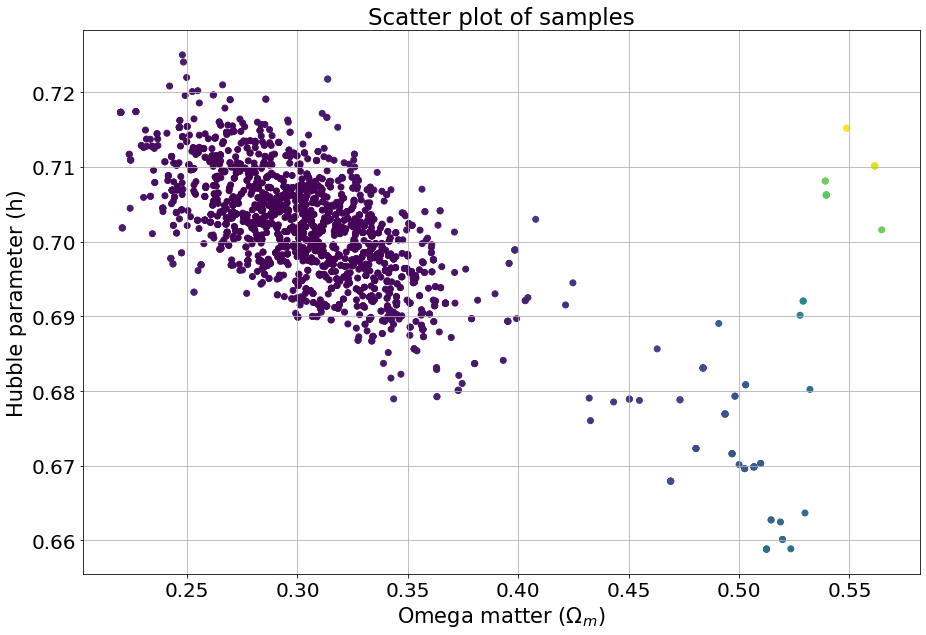

In [7]:
plt.figure(figsize=(15,10))
plt.rcParams['font.size'] = 20
plt.scatter(est_par[:,0], est_par[:,1], c=-est_par[:,2], marker='o')  
plt.title('Scatter plot of samples', fontsize='23')
plt.xlabel('Omega matter ($\Omega_m$)', fontsize='21')
plt.ylabel('Hubble parameter (h)', fontsize='21')
plt.grid(True)
plt.show()

## Burn in

In [8]:
reject = 200               # Initial 10% sampling points are thrown away from total 1000 samples

# Calculating important statistical values
mean_Omega = np.mean(est_par[reject:,0])          # Mean value of omega matter
var_Omega = np.var(est_par[reject:,0])            # Varience of omega matter
mean_h = np.mean(est_par[reject:,1])              # Mean value of h 
var_h = np.var(est_par[reject:,1])                # Varience of h

print("Estimated mean value of Omega matter is =", mean_Omega)
print("Estimated variance of Omega matter is =", var_Omega)
print("Estimated mean value of hubble parameter (h) is =", mean_h)
print("Estimated variance of hubble parameter (h) is =", var_h)

Estimated mean value of Omega matter is = 0.3003423341438093
Estimated variance of Omega matter is = 0.0010233594025125066
Estimated mean value of hubble parameter (h) is = 0.7022915059943595
Estimated variance of hubble parameter (h) is = 5.060006622856574e-05


In [10]:
# Calculating theoritical values of distance modulus as a function of redshift from our estimation

MU_th = np.empty(bins)
for i in range(bins):
    MU_th[i] = mu_th(z[i],mean_Omega,mean_h)

## Plotting the results

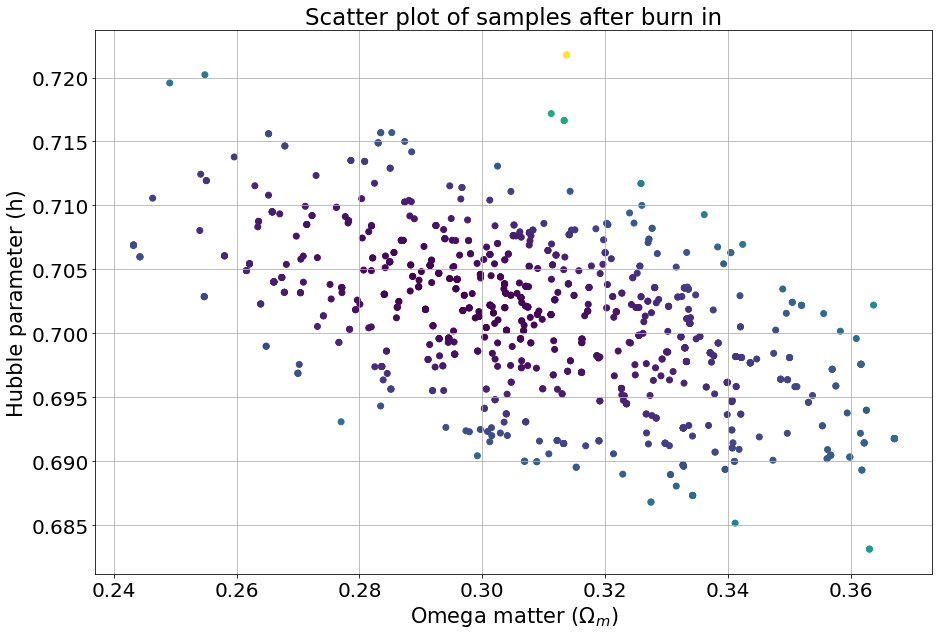

In [11]:
plt.figure(figsize=(15,10))
plt.rcParams['font.size'] = 20
plt.scatter(est_par[reject:,0], est_par[reject:,1], c=-est_par[reject:,2])
plt.title('Scatter plot of samples after burn in', fontsize='23')
plt.xlabel('Omega matter ($\Omega_m$)', fontsize='21')
plt.ylabel('Hubble parameter (h)', fontsize='21')
plt.grid(True)
plt.show()

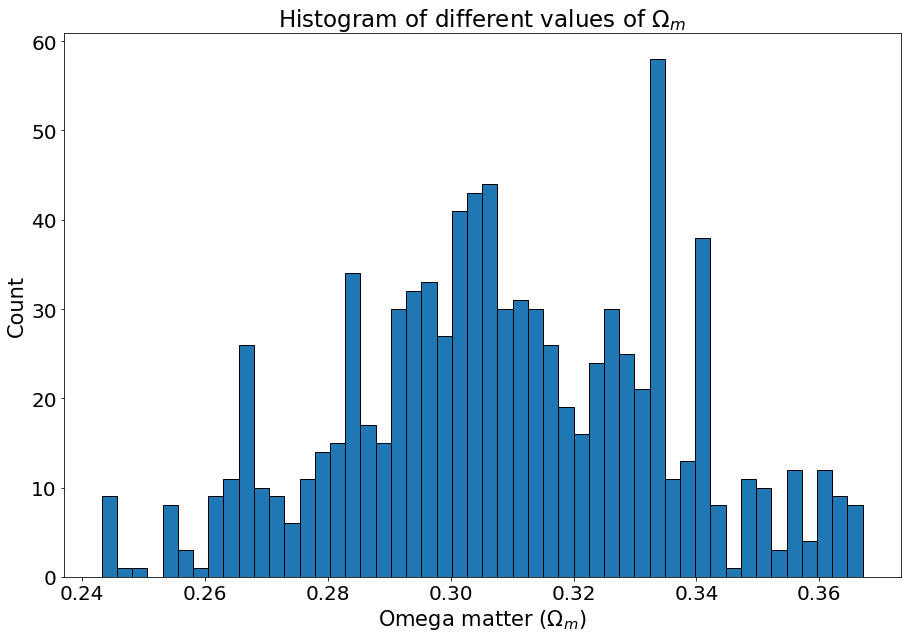

In [12]:
plt.figure(figsize=(15,10))
plt.rcParams['font.size'] = 20
plt.hist(est_par[reject:,0], edgecolor='black', bins=50)
plt.title('Histogram of different values of $\Omega_m$', fontsize='23')
plt.xlabel('Omega matter ($\Omega_m$)', fontsize='21')
plt.ylabel('Count', fontsize='21')
plt.show()

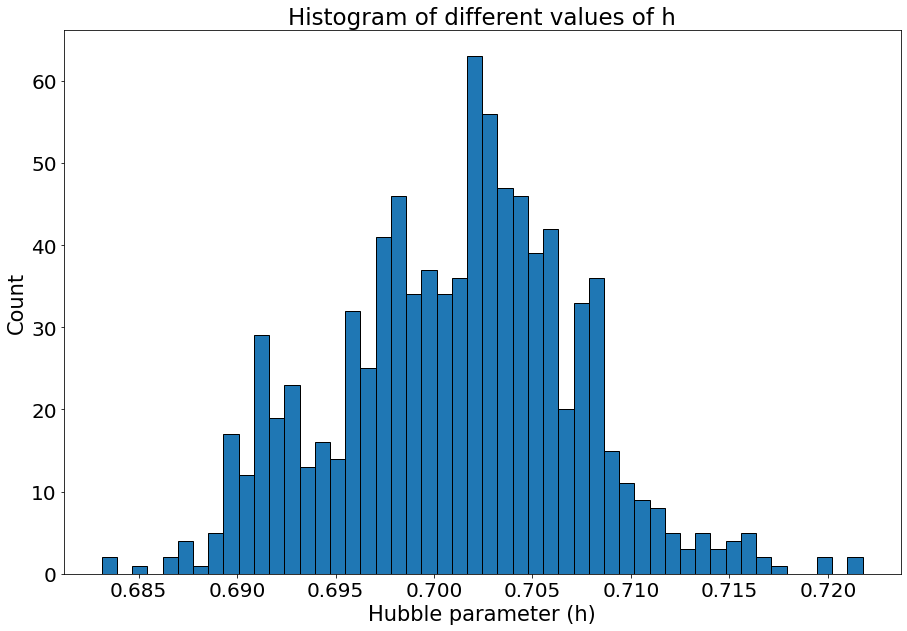

In [13]:
plt.figure(figsize=(15,10))
plt.rcParams['font.size'] = 20
plt.hist(est_par[reject:,1], edgecolor='black', bins=50)
plt.title('Histogram of different values of h', fontsize='23')
plt.xlabel('Hubble parameter (h)', fontsize='21')
plt.ylabel('Count', fontsize='21')
plt.show()

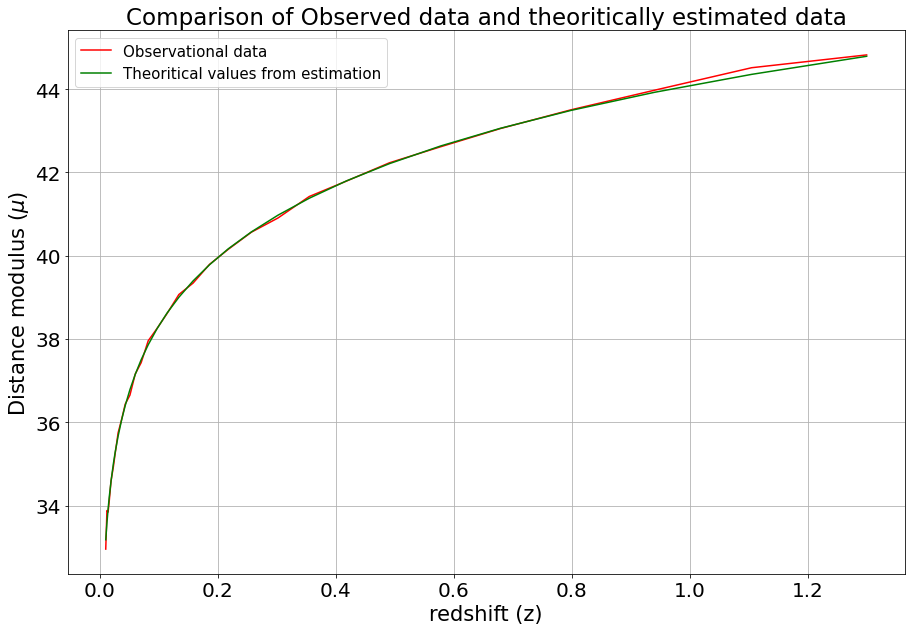

In [14]:
plt.figure(figsize=(15,10))
plt.rcParams['font.size'] = 20
plt.plot(z, mu, color='r', label='Observational data')
plt.plot(z, MU_th, color='g', label='Theoritical values from estimation')
plt.title('Comparison of Observed data and theoritically estimated data', fontsize='23')
plt.xlabel('redshift (z)', fontsize='21')
plt.ylabel('Distance modulus ($\mu$)', fontsize='21')
plt.legend(fontsize='15')
plt.grid(True)
plt.show()